In [1]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt
import tqdm.notebook
# import scipy.integrate

In [2]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [3]:
# Compute a periodic convolution
# Edited from: https://stackoverflow.com/questions/35474078/python-1d-array-circular-convolution
def conv_circ( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
    '''
    if len(ker) < len(signal):
        ker = np.pad(ker, (0, len(signal)-len(ker)))
    return np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(ker) ))

# Generating PF basis 
def generatePFratesBasis(N_PFs = 120, a=5, theta=9):
    # Number of PFs, peak spike rate (Hz), threshold for visual stim velocity
    pf_spike_rates = np.zeros((N_PFs, len(t)))
    # Array of times of peak response of parallel fibers
    delays = np.linspace(0, 1, N_PFs+1) + T_min_full
    for n in range(N_PFs):
        # PF rates are scaled, thresholded versions of the stimulus, 
        # of which each PF receives a time-shifted version
        pf_spike_rates[n,:] = np.maximum(peak_stim_vel*np.cos(2*np.pi*(t - delays[n])) - theta,0)
        pf_spike_rates[n,:] *= a/np.max(pf_spike_rates[n,:])
    return pf_spike_rates

In [4]:
# Simulation time step size (s)
dt = 2e-3

# Total time per block (s)
T_max_full = 0.75
T_min_full = -0.25
T = T_max_full - T_min_full

T_min = 0
t_min_ind = int((T_min-T_min_full)/dt)
T_max = 0.5
t_max_ind = int((T_max - T_min_full)/dt)


# Array of time steps
t = np.arange(0, int(T/dt))*dt + T_min_full

In [54]:
# Eligibility window

dt_mp = dt
T_mp_max = 0.2

t_mp = np.arange(0, int(T_mp_max/dt_mp))*dt_mp

# PF-CF histograms
N_bins = 100
hist_edges = np.linspace(0, T_mp_max, N_bins+1)

In [63]:
## Model parameters

# postsynaptic PC current response to spikes
exc_current_kernel = np.exp(-(t - t[0])/10e-3)

inh_current_kernel = (np.exp(-(t-t[0])/40e-3) - np.exp(-(t-t[0])/10e-3))
inh_current_kernel *= np.sum(exc_current_kernel)/np.sum(inh_current_kernel)

pc_eye_sensitivity = 0.1 # 5
w_max = 5
w_min = 0
w_mli = w_max/2
avg_sensitivity_to_pc = 0.01 # 1/100
retinal_slip_f = lambda x: np.maximum(-x,0)
avg_cf_rate = 1
dw_ltd =  3e-2
dw_ltp = dw_ltd*0.017# 0.016

delay = 0.12
# or
delay_distr = np.exp(-(t_states-0.12)**2/0.005**2)
delay_distr /= np.sum(delay_distr)

decay_rate = 1/(1000) # / s

In [56]:
## Mode rule

dv = 1e-4
N_states = 12
t_states = np.arange(0, int(T_mp_max/dt))*dt
states = np.zeros((len(t_states), N_states))
edges = np.linspace(0, T_mp_max, N_states+1)/dt
for i in range(N_states):
    states[int(edges[i]):int(edges[i+1]),i] = 1 

In [61]:
N_PFs = 120
poisson_peak_rate = 0.477
pf_spike_rates_poisson = poisson_peak_rate*np.ones((N_PFs, len(t)))

In [62]:
pf_spike_rates = np.copy(pf_spike_rates_poisson)
mli_current = dt*conv_circ(np.ones(N_PFs)@pf_spike_rates, exc_current_kernel)

In [68]:
N_repetitions = 1
N_trials = 1000
plasticity = False
metaplasticity = False
cell_wide = False

PF_samples = [0,38,54]
w_0 = w_mli*np.ones(N_PFs)
w_avg_0 = w_mli*np.ones(N_PFs)
v_0 = np.zeros((N_PFs, N_states))
v_0[:,0] = 1

shuffle=False
target_on=False

In [65]:
rng = np.random.default_rng(seed=0)

In [108]:
def simulateLearningModePoisson(N_repetitions, N_trials, w_0, v_0, poisson_peak_rate = 0.477,
                     avg_sensitivity_to_pc = 0.01, 
                     history_samples = 0, PF_samples = [], target_std = 2,
                     metaplasticity = False, shuffle=True):

    inds_random = np.arange(N_PFs)
    # dw_d = np.zeros((repetitions, N_PFs, trials))
    # dw_p = np.zeros((repetitions, N_PFs, trials))

    # dw_d_avg = np.zeros((repetitions,N_PFs, trials))
    # dw_p_avg = np.zeros((repetitions, N_PFs, trials))

    if history_samples == 0:
        history_samples = N_repetitions
    sample_interval = int(np.floor(N_trials/history_samples))
    
    eye_history = np.zeros((N_repetitions, len(t), history_samples))
    eye_history_no_noise = np.zeros((N_repetitions, len(t), history_samples))
    
    hist_history_PF = np.zeros((N_repetitions, len(PF_samples) + 1, N_bins,history_samples))
    state_counts = np.zeros((N_repetitions, len(PF_samples)+1, N_states))
    
    if metaplasticity and len(PF_samples) > 0:
        vs = np.zeros((N_repetitions, len(PF_samples), N_states, history_samples))

    w_final = np.zeros((N_repetitions, N_PFs))
    w_avg_final = np.zeros((N_repetitions, N_PFs))

    cf_prob_avg = np.zeros((N_repetitions, len(t), history_samples)) # Calculate CF probability 
    
    if len(PF_samples) > 0:
        w_test = np.zeros((N_repetitions, len(PF_samples), history_samples))
    w_mean = np.zeros((N_repetitions, history_samples))

    eligibility_windows = v_0@states.T
    
    pf_spike_rates_poisson = poisson_peak_rate*np.ones((N_PFs, len(t)))
    mli_current = dt*conv_circ(np.ones(N_PFs)@pf_spike_rates, exc_current_kernel)

    v = np.copy(v_0)
    
    for rep in tqdm.notebook.trange(N_repetitions):
        w = np.ones(N_PFs)*w_max/2
        n_to_divide = 0
        sample_count = 1
        # w_avg = np.ones(N_PFs)*w_max/2

        hist_history_rep = np.zeros((len(PF_samples)+1, N_bins))
        cf_prob_rep = np.zeros(len(t))
        
        for tt in tqdm.notebook.trange(N_trials, leave=False):  
            if shuffle:
                rng.shuffle(inds_random)

            # Generate PF spikes for sample PC
            pf_spikes = rng.random(size=pf_spike_rates.shape) < pf_spike_rates[inds_random,:]*dt
            pf_spikes_weighted = w@pf_spikes
            pc_current_exc = dt*conv_circ(pf_spikes_weighted/dt, exc_current_kernel)

            # Generate PC firing rate for rest of population
            pc_current_exc_avg_no_noise = dt*conv_circ(w[inds_random]@(pf_spike_rates), exc_current_kernel)

            pc_current = pc_current_exc - w_mli*mli_current
            pc_current_avg_no_noise = pc_current_exc_avg_no_noise - w_mli*mli_current

            # Generate eye movement
            random_target = pc_eye_sensitivity*conv_circ(poisson_peak_rate*rng.standard_normal(len(t)), exc_current_kernel)
            
            eye =  pc_eye_sensitivity*pc_current

            # Calculate retinal slip
            retinal_slip = (random_target*np.sqrt(avg_sensitivity_to_pc*(1-avg_sensitivity_to_pc))
                            - eye*avg_sensitivity_to_pc)

            # Calculate CF probability (here, contraversive RS)
            cf_prob = retinal_slip_f(retinal_slip)
            # Delay the CF probability distribution

            # Rescale so that the average rate over the block is ~1 Hz
            if np.sum(cf_prob) > 0:
                cf_prob /= np.sum(cf_prob)
                cf_prob *= avg_cf_rate*T
            cf_prob_shifted = conv_circ(cf_prob, delay_distr)

            if tt > 0 and tt % sample_interval == 0:
                eye_history[rep,:,sample_count] = pc_eye_sensitivity*pc_current
                eye_history_no_noise[rep, :,sample_count] = pc_eye_sensitivity*pc_current_avg_no_noise
                
                hist_history_PF[rep, :, :, sample_count] += hist_history_rep
                cf_prob_avg[rep, :, sample_count] += cf_prob_rep/n_to_divide
                w_mean[rep, sample_count] = np.mean(w)
                if len(PF_samples) > 0:
                    w_test[rep, :, sample_count] = np.copy(w[PF_samples])
                    if metaplasticity:
                        vs[rep,:, :, sample_count] = np.copy(v[PF_samples,:])
                sample_count += 1
                
            ## Choose CF spikes
            if np.sum(cf_prob) > 0:
                cf_prob_rep += cf_prob_shifted
                n_to_divide += 1
                cf_prob_cdf = np.cumsum(cf_prob_shifted)
                cf_spike_time = np.interp(rng.random(), cf_prob_cdf, t)

            ## Do plasticity
            for j in range(N_PFs):
                eligibility_window = eligibility_windows[j,:]

                for s in np.where(pf_spikes[j,:])[0]:
                    w[j] += dw_ltp

                    if np.sum(cf_prob) > 0:
                        spike_time_1 = cf_spike_time - t[s]
                        # use circular assumption for simplicity
    #                     spike_time_2 = spike_time_1 - T_max_full + T_min_full
                        spike_time_2 = spike_time_1 + T_max_full - T_min_full

                        if 0 <= spike_time_1 <= 0.2 or 0<= spike_time_2 <= 0.2:
                            if 0<=spike_time_1<=0.2:
                                cf_spike_ind = int(np.floor((spike_time_1)/dt))
                                active_timer = np.digitize(spike_time_1, edges*dt)-1
                                hist_bin = np.digitize(spike_time_1, hist_edges)-1
                            else:
                                cf_spike_ind = int(np.floor((spike_time_2)/dt))
                                active_timer = np.digitize(spike_time_2, edges*dt)-1
                                hist_bin = np.digitize(spike_time_2, hist_edges)-1

                            state_counts[rep, 0, active_timer] += 1
                            hist_history_rep[0, hist_bin] += 1
                            for p in range(len(PF_samples)):
                                if j == PF_samples[p]:
                                    state_counts[rep, p+1, active_timer] += 1
                                    hist_history_rep[p+1, hist_bin] += 1

                            ## Plasticity
                            dw = eligibility_window[cf_spike_ind]
                            w[j] -= dw*dw_ltd
                            
                            if metaplasticity:
                                timers_to_update = (v[j,:]>0)
                                timers_to_update[active_timer] = False
                                num_active_timers = np.sum(timers_to_update)

                                if num_active_timers > 0:
                                    dv_minus = np.zeros(N_states)
                                    # Decrease coupling weights of all timers except the most active (ind_to_increase)
                                    dv_minus[timers_to_update] = np.minimum(v[j,timers_to_update], dv)
                                    dv_minus[active_timer] = 0


                                    v[j,:] -= dv_minus

                                    v[j,active_timer] += np.sum(dv_minus)

                if w[j] < w_min: w[j] = w_min
                elif w[j] > w_max: w[j] = w_max
                w[j] += decay_rate*(w_max/2 - w[j])
            if metaplasticity:
                eligibility_windows = v@states.T
        w_final[rep,:] = np.copy(w)
    return_dict = {
        'w_final': w_final,
        'eye_history': eye_history,
        'eye_history_no_noise': eye_history_no_noise,
        'hist_history_PF': hist_history_PF,
        'state_counts': state_counts,
        'cf_prob_avg': cf_prob_avg,
        'v': v,
        'w_mean':w_mean,
    }
    if metaplasticity and len(PF_samples) > 0:
        return_dict['vs'] = vs
    if len(PF_samples) > 0:
        return_dict['w_test'] = w_test
        
    return return_dict
            
            

# Sparse regime

In [171]:
w_mean = np.vstack((sol['w_mean'], sol_2['w_mean'],sol_3['w_mean']))

In [175]:
hist_history = np.vstack((sol['hist_history_PF'], sol_2['hist_history_PF'], sol_3['hist_history_PF']))

In [176]:
state_counts = np.vstack((sol['state_counts'], sol_2['state_counts'],sol_3['state_counts']))

In [177]:
vs = np.vstack((sol['vs'], sol_2['vs'],sol_3['vs']))

In [184]:
np.save('files/integrated simulation/poisson sparse/w_mean.npy',w_mean)
np.save('files/integrated simulation/poisson sparse/hist_history.npy',hist_history)
np.save('files/integrated simulation/poisson sparse/state_counts.npy',state_counts)
np.save('files/integrated simulation/poisson sparse/vs.npy',vs)
np.save('files/integrated simulation/poisson sparse/v.npy', sol_3['v'])

In [379]:
hist_history = np.load('files/integrated simulation/poisson sparse/hist_history.npy')

In [126]:
w_final_1 = np.copy(sol['w_final'])
hist_history_PF_1 = np.copy(sol['hist_history_PF'])
state_counts_1 = np.copy(sol['state_counts'])
v_1 = np.copy(sol['v'])
vs_1 = np.copy(sol['vs'])
w_mean_1 = np.copy(sol['w_mean'])

In [141]:
sol_3 = simulateLearningModePoisson(30, 10000, np.ones(N_PFs)*w_max/2, sol_2['v'], 
                          history_samples = history_samples, PF_samples=[0,38,54], metaplasticity=True, shuffle=False)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

<BarContainer object of 12 artists>

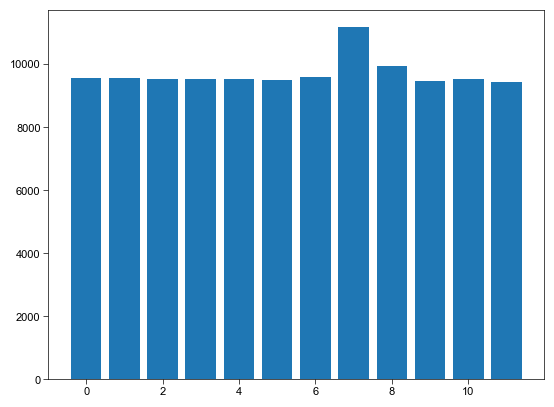

In [134]:
plt.bar(np.arange(N_states), np.sum(sol['state_counts'][:,1,:], axis=0) + 
        np.sum(sol_2['state_counts'][:,1,:],axis=0))

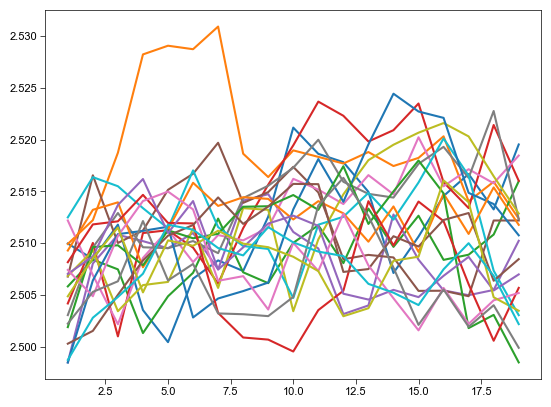

In [137]:
for i in range(20):
    plt.plot(np.arange(1,history_samples), sol['w_mean'][i,1:])

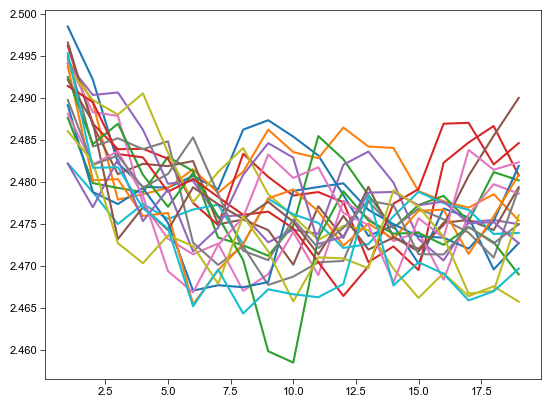

In [138]:
for i in range(20):
    plt.plot(np.arange(1,history_samples), sol_2['w_mean'][i,1:])

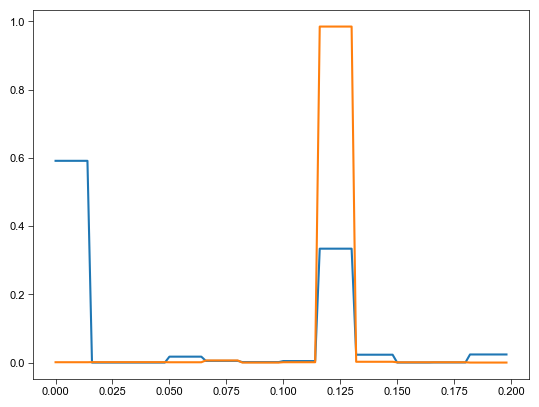

In [375]:
# plt.plot(t_states, sol_3['vs'][-1,0,:,-1]@states.T);
plt.plot(t_states, vs[50,0,:,-1]@states.T); # after 50 rounds of simulation w/ metaplasticity
plt.plot(t_states, vs[-1,0,:,-1]@states.T); # after 150 rounds of simulation w/ metaplasticity

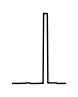

In [393]:
plt.figure(figsize=(0.75,1))

i = 2
plt.plot(t_states, vs[-1,i,:,-1]@states.T, c='k', lw=1)
plt.axis('off')
plt.savefig('figures/sparse-eligibility-end-{0:d}.pdf'.format(i))

In [380]:
hist_all = np.sum(hist_history[:,:,:,-1], axis=0)

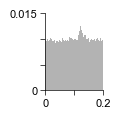

In [385]:
plt.figure(figsize=(0.75,1))

i = 3

plt.bar(hist_edges[:-1], hist_all[i,:]/np.sum(hist_all[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

plt.savefig('figures/sparse-hist-all-3.pdf')

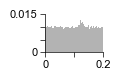

In [167]:
plt.figure(figsize=(0.75,0.5))

i = 1

plt.bar(hist_edges[:-1], hist_end[i,:]/np.sum(hist_end[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

plt.savefig('figures/sparse-hist-end-1.pdf')

In [358]:
hist_early = np.sum(hist_history[:50,:,:,-1],axis=0)

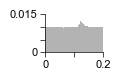

In [359]:
plt.figure(figsize=(0.75,0.5))

i = 0

plt.bar(hist_edges[:-1], hist_early[i,:]/np.sum(hist_early[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

plt.savefig('figures/sparse-hist-early-0.pdf')

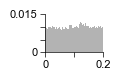

In [362]:
plt.figure(figsize=(0.75,0.5))

i = 3

plt.bar(hist_edges[:-1], hist_early[i,:]/np.sum(hist_early[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

plt.savefig('figures/sparse-hist-early-3.pdf')

In [185]:
pf_spikes = rng.random(size=pf_spike_rates.shape) < pf_spike_rates*dt

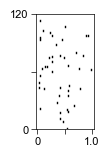

In [211]:
plt.figure(figsize=(0.75,1.5))
for i in range(N_PFs):
    for j in np.where(pf_spikes[i,:])[0]:
        plt.plot([t[j],]*2, [i, i-0.9], c='k',lw=1)
# plt.xlim([T_min_full, T_max_full])
plt.xticks(np.linspace(T_min_full, T_max_full, 3), [0, '', T_max_full-T_min_full])
plt.yticks([0, 60, 120],[0,'',120])
plt.ylim([0, N_PFs])
plt.savefig('figures/sparse-raster.pdf')

# Denser regime

In [307]:
poisson_peak_rate = 2.5
pf_spike_rates_poisson = poisson_peak_rate*np.ones((N_PFs, len(t)))

In [226]:
sol_dense = simulateLearningModePoisson(150, 10000, np.ones(N_PFs)*w_max/2, v_0, poisson_peak_rate = 2.5,
                          history_samples = history_samples, PF_samples=[0,38,54], metaplasticity=True, shuffle=False)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [237]:
sol_dense_2 = simulateLearningModePoisson(150, 10000, np.ones(N_PFs)*w_max/2, sol_dense['v'], poisson_peak_rate = 2.5,
                          history_samples = history_samples, PF_samples=[0,38,54], metaplasticity=True, shuffle=False)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:03<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [394]:
hist_history_dense_3 = np.load('files/integrated simulation/poisson dense/2024-07-14-1153/hist_history.npy')


In [397]:
w_mean_dense_3 = np.load('files/integrated simulation/poisson dense/2024-07-14-1153/w_mean.npy')
v_3 = np.load('files/integrated simulation/poisson dense/2024-07-14-1153/v.npy')

In [396]:
hist_history_dense = np.vstack((hist_history_dense, hist_history_dense_3))

In [325]:
w_mean_dense = np.vstack((sol_dense['w_mean'], sol_dense_2['w_mean']))

In [326]:
hist_history_dense = np.vstack((sol_dense['hist_history_PF'], sol_dense_2['hist_history_PF']))

In [327]:
state_counts_dense = np.vstack((sol_dense['state_counts'], sol_dense_2['state_counts']))

In [328]:
vs_dense = np.vstack((sol_dense['vs'], sol_dense_2['vs']))

In [330]:
np.save('files/integrated simulation/poisson dense/w_mean.npy',w_mean_dense)
np.save('files/integrated simulation/poisson dense/hist_history.npy',hist_history_dense)
np.save('files/integrated simulation/poisson dense/state_counts.npy',state_counts_dense)
np.save('files/integrated simulation/poisson dense/vs.npy',vs_dense)
np.save('files/integrated simulation/poisson dense/v.npy', sol_dense_2['v'])

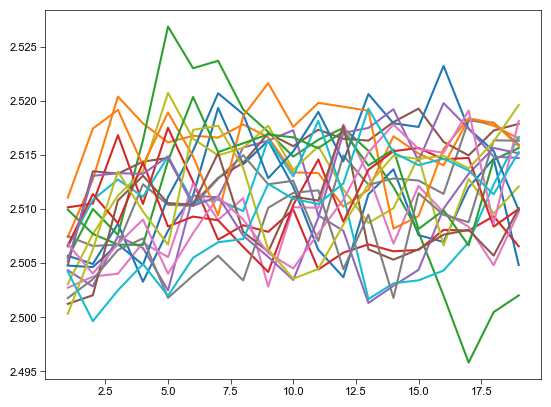

In [227]:
for i in range(20):
    plt.plot(np.arange(1,history_samples), sol_dense['w_mean'][i,1:])

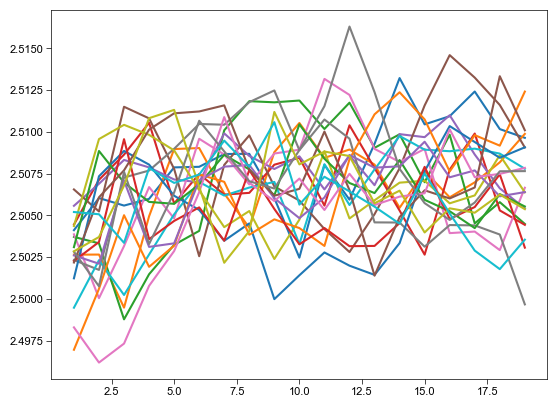

In [256]:
for i in range(20):
    plt.plot(np.arange(1,history_samples), sol_dense_2['w_mean'][-i,1:])

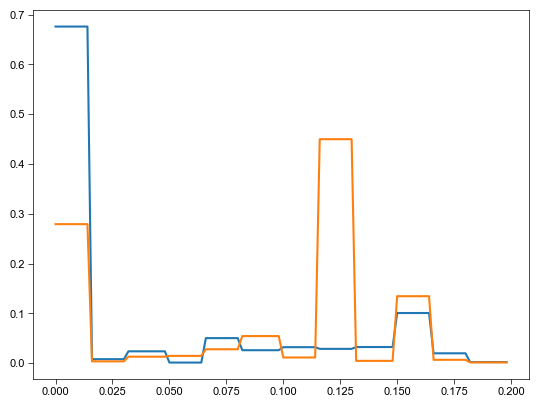

In [355]:
plt.plot(t_states, vs_dense[50,0,:,-1]@states.T); # after 50 simulations
plt.plot(t_states, vs_dense[-1,0,:,-1]@states.T); # after 300 simulations

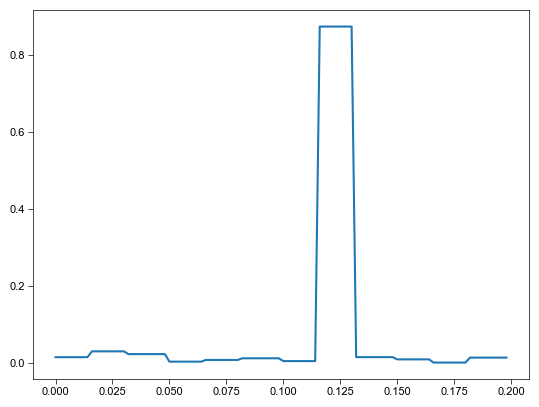

In [404]:
plt.plot(t_states, v_3[0,:]@states.T);

<BarContainer object of 12 artists>

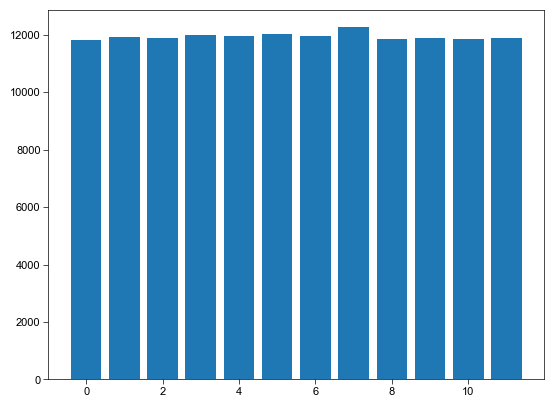

In [374]:
plt.bar(np.arange(N_states), np.sum(state_counts_dense[-150:,3,:], axis=0))

In [405]:
hist_end = np.sum(hist_history_dense[:,:,:,-1], axis=0)

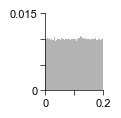

In [417]:
plt.figure(figsize=(0.75,1))

i = 3

plt.bar(hist_edges[:-1], hist_end[i,:]/np.sum(hist_end[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

plt.savefig('figures/dense-hist-all-{0:d}.pdf'.format(i))

In [363]:
hist_mid = np.sum(sol_dense['hist_history_PF'][:150,:,:,-1],axis=0)

[Text(0.0, 0, '0'), Text(0.1, 0, ''), Text(0.2, 0, '0.2')]

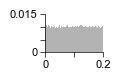

In [364]:
plt.figure(figsize=(0.75,0.5))

i = 3

plt.bar(hist_edges[:-1], hist_mid[i,:]/np.sum(hist_mid[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

# plt.savefig('figures/dense-hist-mid-3.pdf')

In [309]:
pf_spikes = rng.random(size=pf_spike_rates.shape) < pf_spike_rates_poisson*dt

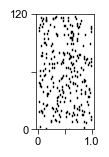

In [311]:
plt.figure(figsize=(0.75,1.5))
for i in range(N_PFs):
    for j in np.where(pf_spikes[i,:])[0]:
        plt.plot([t[j],]*2, [i, i-0.9], c='k',lw=1)
# plt.xlim([T_min_full, T_max_full])

plt.xticks(np.linspace(T_min_full, T_max_full, 3), [0, '', T_max_full-T_min_full])
plt.yticks([0, 60, 120],[0,'',120])
plt.ylim([0, N_PFs])
plt.savefig('figures/dense-raster.pdf')